# Illegal Mining
<hr>
# Notebook Summary

<hr>
# Algorithmic process  

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Get the maximum extents of the datacube](#extents)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Retrieve the data from the datacube](#retrieve_data)
* [Obtain the clean mask](#obtain_clean_mask)
* [Filter out clouds, scan lines, and invalid data](#clean_mask)
* [Examine the selected point](#point_analysis)
* [Examine the selected area](#area_analysis)

<hr>
# How It Works



## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [1]:
%matplotlib inline
# Ignore warnings (from NDVI)
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

# Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_rgb import rgb
import numpy as np
import xarray as xr

# from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Create an instance of the datacube and API.
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

## <a id="plat_prod">Choose Platform and Product</a>

In [3]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
0,LANDSAT_7,ls7_collections_sr_scene
1,LANDSAT_7,ls7_ledaps_ghana
2,LANDSAT_7,ls7_ledaps_ghana_sample


In [4]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,


In [5]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
platform = 'LANDSAT_7'
product = 'ls7_ledaps_ghana_sample'

## <a id="extents">Get the Extents of the Cube</a>

In [6]:
# Get the extents of the cube
descriptor = api.get_query_metadata(platform=platform, product=product)

# Save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']
    
# Determine minimum and maximum longitudes that bound a common area among products
full_lon = (min_lon, max_lon)
full_lat = (min_lat, max_lat)
# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

## <a id="define_extents">Define the Extents of the Analysis</a>

**Specify an area and a point within it to analyze**

In [7]:
print(descriptor)

{'tile_count': 12, 'lon_extents': (-1.886462096652, -1.409726175369516), 'pixel_count': 11045636, 'lat_extents': (7.749586293046416, 9.43231048326), 'time_extents': (datetime.datetime(2015, 4, 16, 10, 26, 29), datetime.datetime(2016, 4, 2, 10, 29, 25))}


**Extents that don't load**

In [8]:
# OOB
# min_lat_small, max_lat_small = (5.45, 5.55) # Ghana (Illegal Mining - Tarkwa Forest District - OOB)
# min_lon_small, max_lon_small = (-1.9, -1.8) # Ghana (Illegal Mining - Tarkwa Forest District - OOB)

# Unknown
# min_lat_small, max_lat_small = (6.1, 6.25) # Ghana (Illegal Mining - median)
# min_lon_small, max_lon_small = (-1.5, -1.35) # Ghana (Illegal Mining - median)
# min_lat_small, max_lat_small = (6.1, 6.2) # Ghana (Illegal Mining - Kade Forest District)
# min_lon_small, max_lon_small = (-0.85, -0.75) # Ghana (Illegal Mining - Kade Forest District)

# lat_point, lon_point = (6.203758489, -1.419891117) #(Illegal Mining - median)

**Extents that load**

In [9]:
# Specify latitude and longitude bounds of an interesting area within the full extents.
# shown in the metadata report above (reduce area for faster processing times).

min_lat_small, max_lat_small = (8.85, 8.9) # Ghana (small)
min_lon_small, max_lon_small = (-1.75, -1.7) # Ghana (small)
# min_lat_small, max_lat_small = (6.2, 6.4) # Ghana (Illegal Mining - Bibiani Forest District)
# min_lon_small, max_lon_small = (-2.25, -2.05) # Ghana (Illegal Mining - Bibiani Forest District)
# min_lat_small, max_lat_small = (8.4, 9.4) # Ghana (full)
# min_lon_small, max_lon_small = (-1.6, -0.6) # Ghana (full)
# min_lat_small, max_lat_small = (0.6619, 0.6719) # Lake Baringo
# min_lon_small, max_lon_small = (36.1376, 36.1437) # Lake Baringo

# min_lat_small, max_lat_small = (6.225, 6.3) # Ghana (Illegal Mining - Begoro Forest District)
# min_lon_small, max_lon_small = (-0.575,-0.525) # Ghana (Illegal Mining - Begoro Forest District)
# min_lat_small, max_lat_small = (5.05, 5.15) # Ghana (Ampansie - Southwest - Brian region)
# min_lon_small, max_lon_small = (-2.30,-2.20) # Ghana (Ampansie - Southwest - Brian region)
# min_lat_small, max_lat_small = (6.7083,6.7285) # Ghana (research paper)
# min_lon_small, max_lon_small = (-2.0750,-2.0183) # Ghana (research paper)

# Choose an interesting point within the specified area (a pixel, not an area).
lat_point, lon_point = (8.875, -1.70)
# lat_point, lon_point = (5.12, -2.24) # Ghana (Ampansie - Southwest -Brian region)
# lat_point, lon_point = (6.7204, -2.0266) # Ghana (research paper - POI 1)
# lat_point, lon_point = (6.7176, -2.0310) # Ghana (research paper - POI 2)

**Visualize the selected area**

In [10]:
lon_small = (min_lon_small, max_lon_small)
lat_small = (min_lat_small, max_lat_small)
display_map(lat_small, lon_small)

**Visualize the selected point**

In [11]:
display_map((lat_point, lat_point), (lon_point, lon_point))

## <a id="retrieve_data">Retrieve the data from the datacube</a>

In [12]:
from datetime import datetime as dt
measurements = ['red', 'pixel_qa', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
start_date, end_date = min_date, max_date
# Query the Data Cube
dataset_in = dc.load(lat = lat_small,
                     lon = lon_small,
                     platform = platform,
                     time = (start_date, end_date),
                     product = product,
                     measurements = measurements)
dataset_point = dc.load(lat = (lat_point, lat_point),
                        lon = (lon_point, lon_point),
                        platform = platform,
                        time = (start_date, end_date),
                        product = product,
                        measurements = measurements)

In [13]:
print(dataset_in)
print(dataset_point)

<xarray.Dataset>
Dimensions:    (latitude: 186, longitude: 186, time: 11)
Coordinates:
  * time       (time) datetime64[ns] 2015-04-16T10:26:29 2015-08-06T10:27:04 ...
  * latitude   (latitude) float64 8.9 8.9 8.899 8.899 8.899 8.899 8.898 ...
  * longitude  (longitude) float64 -1.75 -1.75 -1.749 -1.749 -1.749 -1.749 ...
Data variables:
    red        (time, latitude, longitude) int16 1447 1472 1499 1552 1552 ...
    pixel_qa   (time, latitude, longitude) int32 66 66 66 66 66 66 66 66 66 ...
    blue       (time, latitude, longitude) int16 1216 1243 1243 1243 1243 ...
    green      (time, latitude, longitude) int16 1408 1378 1408 1437 1437 ...
    nir        (time, latitude, longitude) int16 2949 2987 2949 2949 2949 ...
    swir1      (time, latitude, longitude) int16 2354 2421 2489 2659 2523 ...
    swir2      (time, latitude, longitude) int16 1632 1703 1809 1950 1809 ...
Attributes:
    crs:      EPSG:4326
<xarray.Dataset>
Dimensions:    (latitude: 1, longitude: 1, time: 11)
Coordin

## <a id="obtain_clean_mask">Obtain the clean masks</a>

**For more information on masking, please refer to Masking_Notebook.**

In [14]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Get the clean mask for the LANDSAT satellite platform
clean_mask = landsat_qa_clean_mask(dataset_in, platform)

## <a id="clean_mask">Filter out clouds, scan lines, and invalid data</a>

In [15]:
# Remove clouds and Landsat 7 scan lines.
cleaned_dataset = dataset_in.where(clean_mask)
# Remove data that is ouside the accepted range of LANDSAT 7 and 8.
cleaned_dataset = landsat_clean_mask_invalid(cleaned_dataset)

## <a id="point_analysis">Examine the selected point</a>

In [16]:
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

ndvi_arr = NDVI(cleaned_dataset)
ndvi_arr_point = ndvi_arr.sel(latitude=lat_point, longitude=lon_point, method='nearest')
wofs_arr = wofs_classify(cleaned_dataset, clean_mask).wofs
wofs_arr = wofs_arr.where(wofs_arr!=-9999)
wofs_arr_point = wofs_arr.sel(latitude=lat_point, longitude=lon_point, method='nearest')
ndvi_wofs_combined = xr.Dataset({'ndvi':ndvi_arr, 'wofs':wofs_arr})

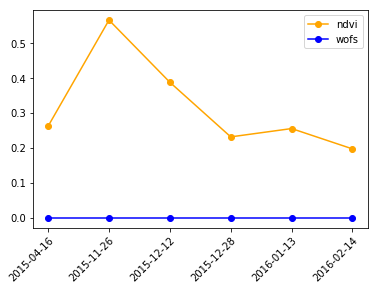

In [17]:
import utils.data_cube_utilities.plotter_utils as plotter_utils
import importlib
importlib.reload(plotter_utils)
from utils.data_cube_utilities.plotter_utils import xarray_plot_data_vars_over_time
ndvi_wofs_combined_point = ndvi_wofs_combined.sel(latitude=lat_point, longitude=lon_point, method='nearest')
xarray_plot_data_vars_over_time(ndvi_wofs_combined_point)

In [18]:
print(ndvi_wofs_combined_point)

<xarray.Dataset>
Dimensions:    (time: 11)
Coordinates:
  * time       (time) datetime64[ns] 2015-04-16T10:26:29 2015-08-06T10:27:04 ...
    latitude   float64 8.875
    longitude  float64 -1.7
Data variables:
    wofs       (time) float64 0.0 nan nan nan 0.0 0.0 0.0 0.0 nan 0.0 nan
    ndvi       (time) float64 0.2623 nan nan nan 0.566 0.3879 0.2315 0.2553 ...


## <a id="area_analysis">Examine the selected area</a>

**Make a box plot by week of year**

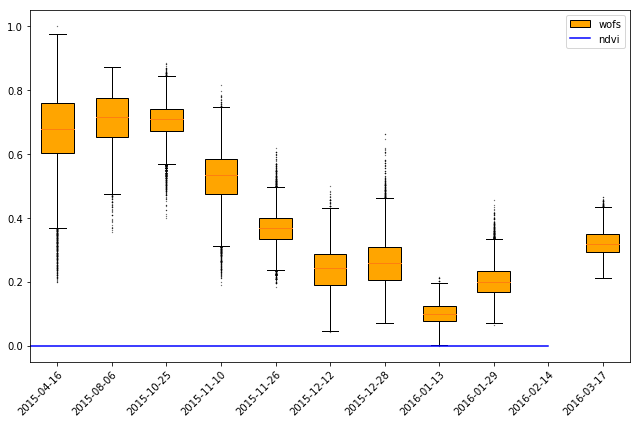

In [19]:
importlib.reload(plotter_utils)
from utils.data_cube_utilities.plotter_utils import xarray_plot_ndvi_boxplot_wofs_lineplot_over_time
xarray_plot_ndvi_boxplot_wofs_lineplot_over_time(ndvi_wofs_combined)

**Plot the medians, means, linear regression of means, Gaussian smoothed curve of means, and a band spanning between the 75h percentiles and 25th percentiles** 

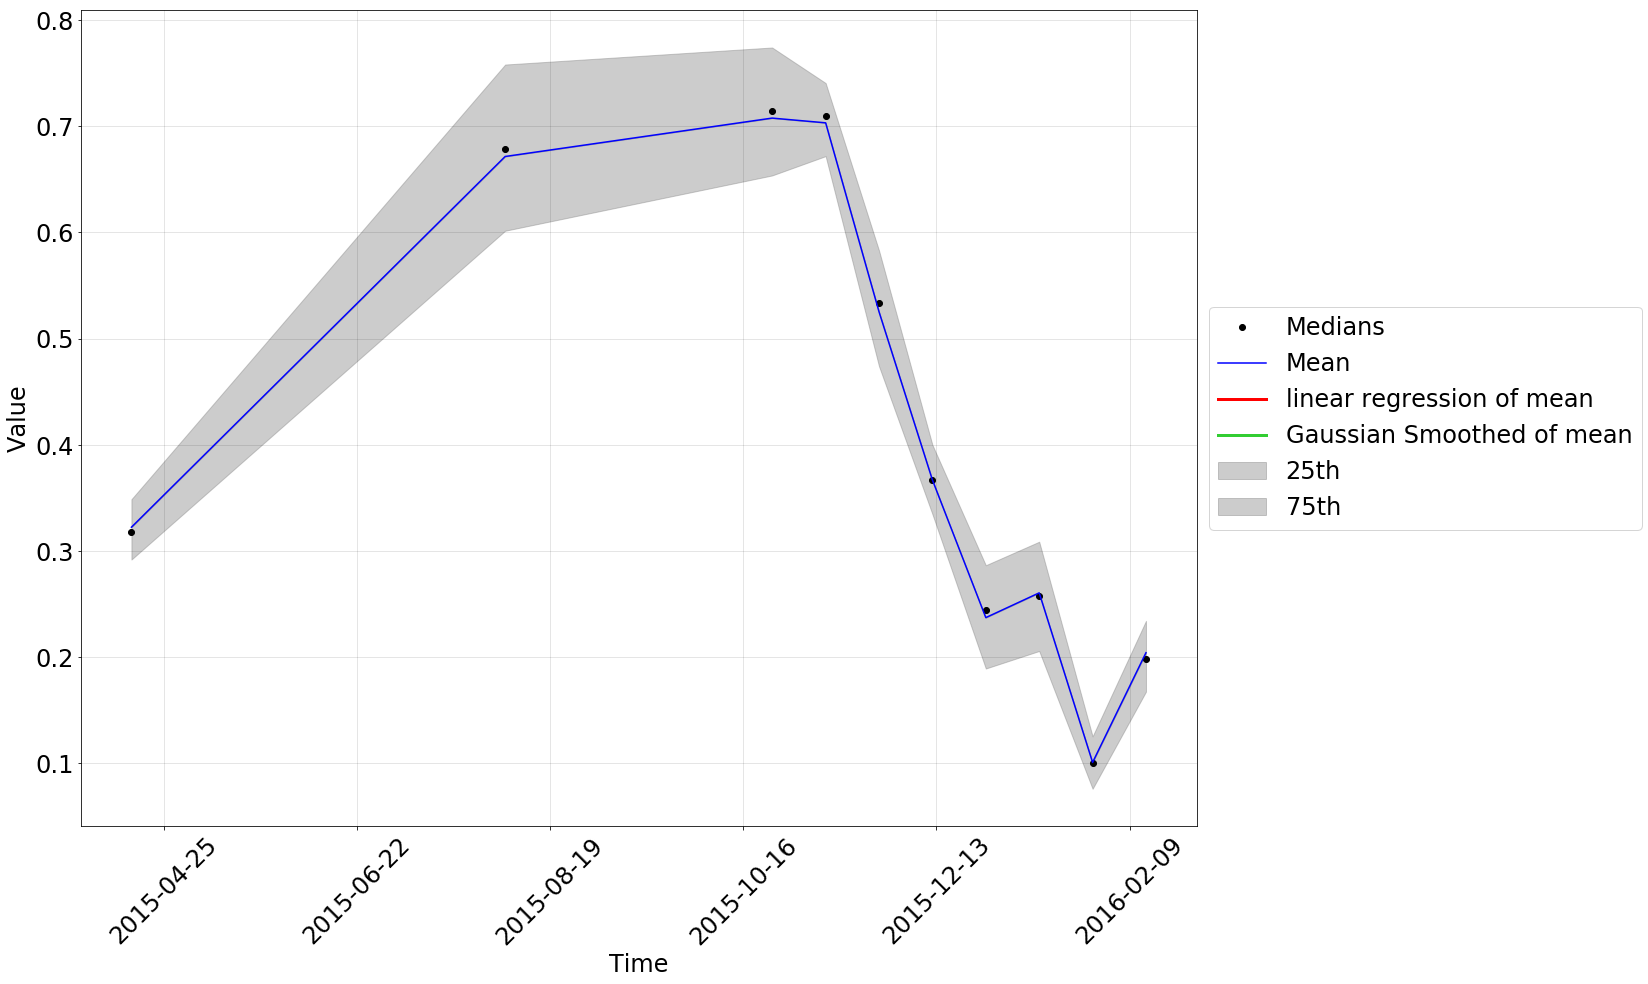

In [20]:
from utils.data_cube_utilities.plotter_utils import plot_band
plot_band(cleaned_dataset, ndvi_arr)